<a href="https://colab.research.google.com/github/juancgar/GeoVisualisation-Python/blob/main/GeoBigData_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Maquina Virtual

In [ ]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.6 LTS
Release:	18.04
Codename:	bionic


In [ ]:
!lscpu | grep -E '^Model name|^Thread|^Core|^Socket|^CPU\('

CPU(s):              4
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!free -m -h

              total        used        free      shared  buff/cache   available
Mem:            25G        861M         22G        1.2M        2.5G         24G
Swap:            0B          0B          0B


In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         226G   23G  204G  10% /
tmpfs            64M     0   64M   0% /dev
shm              13G     0   13G   0% /dev/shm
/dev/root       2.0G  1.1G  910M  54% /sbin/docker-init
tmpfs            13G   32K   13G   1% /var/colab
/dev/sda1       233G   24G  209G  11% /etc/hosts
tmpfs            13G     0   13G   0% /proc/acpi
tmpfs            13G     0   13G   0% /proc/scsi
tmpfs            13G     0   13G   0% /sys/firmware


In [ ]:
!lsblk -d -o name,rota

NAME  ROTA
loop0    0
sda      0


Instalación de Requerimientos

In [1]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.2/spark-3.2.2-bin-hadoop3.2.tgz
!tar xf spark-3.2.2-bin-hadoop3.2.tgz
!pip -q install findspark

In [2]:
! java -version

openjdk version "11.0.16" 2022-07-19
OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04)
OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.2-bin-hadoop3.2"

In [4]:
!pip -q install pyspark

     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 199 kB 52.8 MB/s 


In [5]:
!pip -q install geopandas attrs shapely rtree apache-sedona[spark]

     |████████████████████████████████| 1.0 MB 13.9 MB/s 
     |████████████████████████████████| 1.0 MB 64.0 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
     |████████████████████████████████| 6.3 MB 41.2 MB/s 
     |████████████████████████████████| 16.7 MB 40.5 MB/s 


Descarga de Bases de Datos Listas para el Análisis

In [6]:
#Descarga de Bases de Datos SCINCE 2020 y DENUE Mayo 2022

!gdown 1erwHX0ZtIPiTYP5rYPZzaj2TgpWG9TdT
!gdown 1g5cFmQ81ngZNVjcuBeOJOCrubeDoBazS

Downloading...
From: https://drive.google.com/uc?id=1erwHX0ZtIPiTYP5rYPZzaj2TgpWG9TdT
To: /content/SCINCE_Parquets.zip
100% 1.14G/1.14G [00:14<00:00, 79.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1g5cFmQ81ngZNVjcuBeOJOCrubeDoBazS
To: /content/DENUE_Parquets.zip
100% 486M/486M [00:05<00:00, 90.7MB/s]


Descompactar los Datos

In [7]:
!ls /content/*.zip

/content/DENUE_Parquets.zip  /content/SCINCE_Parquets.zip


In [8]:
!unzip /content/DENUE_Parquets.zip -d /content/DENUE_Parquets/ &> /dev/null

In [9]:
!unzip /content/SCINCE_Parquets.zip -d /content/SCINCE_Parquets/ &> /dev/null

In [10]:
!ls /content/DENUE_Parquets

01.parquet  07.parquet	13.parquet    18.parquet  24.parquet  30.parquet
02.parquet  08.parquet	14.parquet    19.parquet  25.parquet  31.parquet
03.parquet  09.parquet	15_1.parquet  20.parquet  26.parquet  32.parquet
04.parquet  10.parquet	15_2.parquet  21.parquet  27.parquet
05.parquet  11.parquet	16.parquet    22.parquet  28.parquet
06.parquet  12.parquet	17.parquet    23.parquet  29.parquet


Inicio de Apache Spark y Apache Sedona

In [11]:
import findspark
findspark.init()
import shapely
import pandas as pd 
import geopandas as gpd
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
spark = SparkSession. \
builder. \
appName('GeoBigData'). \
config("spark.serializer", KryoSerializer.getName). \
config("spark.executor.memory", "5g"). \
config("spark.driver.memory", "10g"). \
config('spark.driver.maxResultSize', '5g'). \
config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.2.0-incubating,'
           'org.datasyslab:geotools-wrapper:1.1.0-25.2'). \
getOrCreate()
SedonaRegistrator.registerAll(spark)

True

Leer Datos

In [12]:
BD_MANZANAS = spark.read.parquet(f"SCINCE_Parquets/19_NL.parquet")
BD_MANZANAS_EEVVV = BD_MANZANAS.select('CVEGEO', 'ECO1_R', 'EDU46_R', 'VIV82_R', 'VIV83_R', 'VIV84_R', 'geometry')
BD_MANZANAS_EEVVV.cache()
BD_MANZANAS_EEVVV.printSchema()
BD_MANZANAS_EEVVV.show()

root
 |-- CVEGEO: string (nullable = true)
 |-- ECO1_R: double (nullable = true)
 |-- EDU46_R: double (nullable = true)
 |-- VIV82_R: double (nullable = true)
 |-- VIV83_R: double (nullable = true)
 |-- VIV84_R: double (nullable = true)
 |-- geometry: geometry (nullable = true)

+----------------+------+-------+-------+-------+-------+--------------------+
|          CVEGEO|ECO1_R|EDU46_R|VIV82_R|VIV83_R|VIV84_R|            geometry|
+----------------+------+-------+-------+-------+-------+--------------------+
|1900100010021001|  53.7|   10.6|   75.0|   30.0|   40.0|POLYGON ((2659352...|
|1900100010021007|  54.5|   12.2|   61.9|   19.0|   19.0|POLYGON ((2659829...|
|1900100010021020|  -6.0|   -6.0|   -6.0|   -6.0|   -6.0|POLYGON ((2659830...|
|1900100010021037|  -8.0|   -8.0|   -8.0|   -8.0|   -8.0|POLYGON ((2659506...|
|1900100010021047|  66.7|   -6.0|   -6.0|   -6.0|   -6.0|POLYGON ((2659550...|
|1900100010036010|  46.2|   -6.0|   55.6|   33.3|   -6.0|POLYGON ((2660761...|
|19001000

In [13]:
BD_MANZANAS_EEVVV.createOrReplaceTempView("manzanas")

In [14]:
BD_MZA_EEVVV_CORREGIDO = spark.sql("""select 
                                  CVEGEO,
                                  if( (isnull(ECO1_R) or ECO1_R < 0 ), 0, ECO1_R) as ECO1_R, 
                                  if( (isnull(EDU46_R) or EDU46_R < 0 ), 0, EDU46_R) as EDU46_R,
                                  if( (isnull(VIV82_R) or VIV82_R < 0 ), 0, VIV82_R) as VIV82_R,
                                  if( (isnull(VIV83_R) or VIV83_R < 0 ), 0, VIV83_R) as VIV83_R,
                                  if( (isnull(VIV84_R) or VIV84_R < 0 ), 0, VIV84_R) as VIV84_R,                                  
                                  geometry
                             from manzanas """)

BD_MZA_EEVVV_CORREGIDO.cache()
BD_MZA_EEVVV_CORREGIDO.show()

+----------------+------+-------+-------+-------+-------+--------------------+
|          CVEGEO|ECO1_R|EDU46_R|VIV82_R|VIV83_R|VIV84_R|            geometry|
+----------------+------+-------+-------+-------+-------+--------------------+
|1900100010021001|  53.7|   10.6|   75.0|   30.0|   40.0|POLYGON ((2659352...|
|1900100010021007|  54.5|   12.2|   61.9|   19.0|   19.0|POLYGON ((2659829...|
|1900100010021020|   0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659830...|
|1900100010021037|   0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659506...|
|1900100010021047|  66.7|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659550...|
|1900100010036010|  46.2|    0.0|   55.6|   33.3|    0.0|POLYGON ((2660761...|
|1900100010036012|  43.8|   10.3|   43.8|    0.0|    0.0|POLYGON ((2660950...|
|1900200010207030|  50.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2744874...|
|1900200010211013|  30.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2744393...|
|1900200010211018|   0.0|    0.0|    0.0|    0.0|   

In [15]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

vecAssembler = VectorAssembler(inputCols=["ECO1_R", "EDU46_R", "VIV82_R", "VIV83_R", "VIV84_R"], outputCol="features")
BD_MZA_EEVVV_CORREGIDO_VEC = vecAssembler.transform(BD_MZA_EEVVV_CORREGIDO)
BD_MZA_EEVVV_CORREGIDO_VEC.cache()
BD_MZA_EEVVV_CORREGIDO_VEC.show()

+----------------+------+-------+-------+-------+-------+--------------------+--------------------+
|          CVEGEO|ECO1_R|EDU46_R|VIV82_R|VIV83_R|VIV84_R|            geometry|            features|
+----------------+------+-------+-------+-------+-------+--------------------+--------------------+
|1900100010021001|  53.7|   10.6|   75.0|   30.0|   40.0|POLYGON ((2659352...|[53.7,10.6,75.0,3...|
|1900100010021007|  54.5|   12.2|   61.9|   19.0|   19.0|POLYGON ((2659829...|[54.5,12.2,61.9,1...|
|1900100010021020|   0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659830...|           (5,[],[])|
|1900100010021037|   0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659506...|           (5,[],[])|
|1900100010021047|  66.7|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659550...|      (5,[0],[66.7])|
|1900100010036010|  46.2|    0.0|   55.6|   33.3|    0.0|POLYGON ((2660761...|[46.2,0.0,55.6,33...|
|1900100010036012|  43.8|   10.3|   43.8|    0.0|    0.0|POLYGON ((2660950...|[43.8,10.3,43.8,0...|


In [16]:
kmeans = KMeans(k=5, seed=1, maxIter=250) 
model = kmeans.fit(BD_MZA_EEVVV_CORREGIDO_VEC.select('features'))
transformed = model.transform(BD_MZA_EEVVV_CORREGIDO_VEC)
transformed.show()

+----------------+------+-------+-------+-------+-------+--------------------+--------------------+----------+
|          CVEGEO|ECO1_R|EDU46_R|VIV82_R|VIV83_R|VIV84_R|            geometry|            features|prediction|
+----------------+------+-------+-------+-------+-------+--------------------+--------------------+----------+
|1900100010021001|  53.7|   10.6|   75.0|   30.0|   40.0|POLYGON ((2659352...|[53.7,10.6,75.0,3...|         0|
|1900100010021007|  54.5|   12.2|   61.9|   19.0|   19.0|POLYGON ((2659829...|[54.5,12.2,61.9,1...|         3|
|1900100010021020|   0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659830...|           (5,[],[])|         1|
|1900100010021037|   0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659506...|           (5,[],[])|         1|
|1900100010021047|  66.7|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659550...|      (5,[0],[66.7])|         2|
|1900100010036010|  46.2|    0.0|   55.6|   33.3|    0.0|POLYGON ((2660761...|[46.2,0.0,55.6,33...|         3|
|

In [17]:
transformed.createOrReplaceTempView("result_kmeans")
clusters = spark.sql(""" select prediction, 
    mean(ECO1_R) as mean_econ_activa, 
    mean(EDU46_R) as mean_educ_superior,
    mean(VIV82_R) as mean_tv_paga,
    mean(VIV83_R) as mean_streaming,
    mean(VIV84_R) as mean_videojuegos,
    count(*) as conteo
from result_kmeans group by prediction order by mean_econ_activa""")

clusters.show()

+----------+------------------+------------------+--------------------+--------------------+--------------------+------+
|prediction|  mean_econ_activa|mean_educ_superior|        mean_tv_paga|      mean_streaming|    mean_videojuegos|conteo|
+----------+------------------+------------------+--------------------+--------------------+--------------------+------+
|         1|0.3817844096340782|0.1879945514209647|0.057742554640579535|0.012191195591604236|2.971952201102099E-4| 16151|
|         0| 60.45407367207122| 37.89760531849947|  54.780713655790024|  39.017732853944885|  20.745939895529506| 14741|
|         3|60.616355419118264| 9.940048605781554|  50.899266649611924|  12.775765327875876|    7.34943719621387| 23454|
|         2| 62.13703205381869| 8.266489908982965|  13.683917688959232|   4.480878512069648|  2.6638702018203433| 12635|
|         4| 63.41251248252447| 75.31563810665062|   70.30144797283802|   69.46933293389252|   40.79018374276021| 10014|
+----------+------------------+-

In [18]:
df_clusters = clusters.toPandas()

In [19]:
df_clusters

prediction  mean_econ_activa  mean_educ_superior  mean_tv_paga  \
0           1          0.381784            0.187995      0.057743   
1           0         60.454074           37.897605     54.780714   
2           3         60.616355            9.940049     50.899267   
3           2         62.137032            8.266490     13.683918   
4           4         63.412512           75.315638     70.301448   

   mean_streaming  mean_videojuegos  conteo  
0        0.012191          0.000297   16151  
1       39.017733         20.745940   14741  
2       12.775765          7.349437   23454  
3        4.480879          2.663870   12635  
4       69.469333         40.790184   10014

In [20]:
import numpy as np
import matplotlib.pyplot as plt

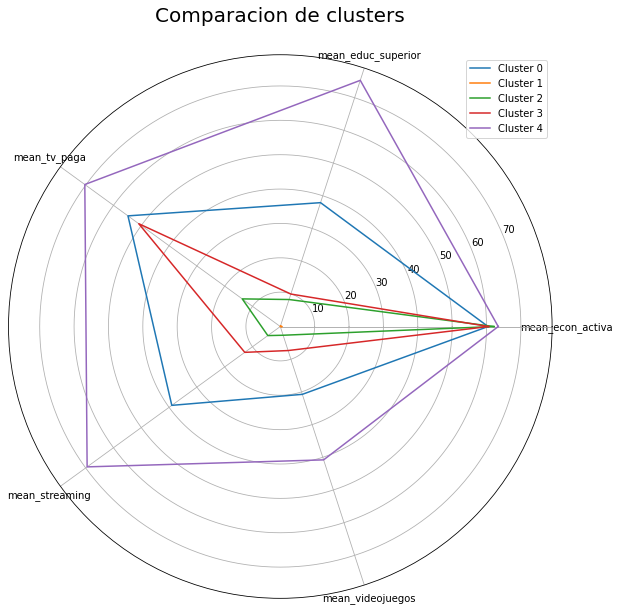

In [21]:
categories = df_clusters.columns[1:-1].values
cluster_0 = df_clusters.where(df_clusters.prediction==0).dropna().values[0][1:-1]
cluster_1 = df_clusters.where(df_clusters.prediction==1).dropna().values[0][1:-1]
cluster_2 = df_clusters.where(df_clusters.prediction==2).dropna().values[0][1:-1]
cluster_3 = df_clusters.where(df_clusters.prediction==3).dropna().values[0][1:-1]
cluster_4 = df_clusters.where(df_clusters.prediction==4).dropna().values[0][1:-1]

cluster_0 = [*cluster_0,cluster_0[0]]
cluster_1 = [*cluster_1,cluster_1[0]]
cluster_2 = [*cluster_2,cluster_2[0]]
cluster_3 = [*cluster_3,cluster_3[0]]
cluster_4 = [*cluster_4,cluster_4[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster_0))

plt.figure(figsize=(10, 10))
plt.subplot(polar=True)
plt.plot(label_loc, cluster_0, label='Cluster 0')
plt.plot(label_loc, cluster_1, label='Cluster 1')
plt.plot(label_loc, cluster_2, label='Cluster 2')
plt.plot(label_loc, cluster_3, label='Cluster 3')
plt.plot(label_loc, cluster_4, label='Cluster 4')
plt.title('Comparacion de clusters', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

In [22]:
#Verde = Cluster 4
#Amarillo = Cluster 3 ; Cluster 0
#Rojo = Cluster 1 ; Cluster 2

Visualización de Datos

In [23]:
df_manzanas = spark.sql("""select ECO1_R as eco_act,
                                  EDU46_R as edu_sup,
                                  VIV82_R as tv_paga,
                                  VIV83_R as stream,
                                  VIV84_R as videoj,
                                  geometry,
                                  prediction 
                           from result_kmeans""").toPandas()
geopandas_df_grid = gpd.GeoDataFrame(df_manzanas, geometry="geometry")
geopandas_df_grid = geopandas_df_grid.set_crs('PROJCS["Mexico_ITRF2008_LCC",GEOGCS["Mexico_ITRF2008",DATUM["Mexico_ITRF2008",SPHEROID["GRS_1980",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP",AUTHORITY["EPSG","9802"]],PARAMETER["Central_Meridian",-102],PARAMETER["Latitude_Of_Origin",12],PARAMETER["False_Easting",2500000],PARAMETER["False_Northing",0],PARAMETER["Standard_Parallel_1",17.5],PARAMETER["Standard_Parallel_2",29.5],PARAMETER["Scale_Factor",1],UNIT["Meter",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6372"]]')
geopandas_df_grid = geopandas_df_grid.to_crs("EPSG:4326")
#geopandas_df_grid.to_file("/content/drive/MyDrive/GeoBigDataNube2022/resultados/manzanas_kmeans.shp")

In [24]:
df_manzanas.head()


eco_act  edu_sup  tv_paga  stream  videoj  \
0     53.7     10.6     75.0    30.0    40.0   
1     54.5     12.2     61.9    19.0    19.0   
2      0.0      0.0      0.0     0.0     0.0   
3      0.0      0.0      0.0     0.0     0.0   
4     66.7      0.0      0.0     0.0     0.0   

                                            geometry  prediction  
0  POLYGON ((2659352.328 1544982.810, 2659338.381...           0  
1  POLYGON ((2659829.700 1545077.827, 2659822.522...           3  
2  POLYGON ((2659830.871 1544885.594, 2659809.370...           1  
3  POLYGON ((2659506.144 1544614.934, 2659508.565...           1  
4  POLYGON ((2659550.796 1545042.810, 2659536.731...           2

In [25]:
import folium

In [26]:
def rank_colormap(gdf):
  if gdf['properties']['prediction'] is 3:
    return 'green'
  if gdf['properties']['prediction'] is 2 or 4:
    return 'yellow'
  if gdf['properties']['prediction'] is 1 or 0:
    return 'red'

In [27]:
m = folium.Map(location=[25.6874497034792, -100.31542346702768], zoom_start=14)

folium.GeoJson(data = geopandas_df_grid, name="Estratos",style_function = lambda feature: {
   'fillColor': rank_colormap(feature),
   'color': rank_colormap(feature),
   'weight': '0.5',
   'fill': True,
   'fill_opacity': '1'
}).add_to(m)

In [28]:
m

In [ ]:
m.save("map.html")

Mapa de Densidad de Farmacias

In [ ]:
BD_DENUE = spark.read.parquet(f"/content/DENUE_Parquets/19.parquet")
BD_DENUE.createOrReplaceTempView("denue")
BD_DENUE.cache()
BD_DENUE.count()

In [ ]:
Influencia_Mineria = spark.sql("""select 
                                  CVEGEO,
                                  ECO1_R as eco_act,
                                  EDU46_R as edu_sup,
                                  VIV82_R as tv_paga,
                                  VIV83_R as stream,
                                  VIV84_R as videoj,
                                  result_kmeans.geometry,
                                  prediction,
                                  count(*) as cont
                           from result_kmeans,
                                denue
                            where denue.codigo_act like '21%' and
                                  ST_Intersects(result_kmeans.geometry , ST_Buffer(denue.geometry,1500)) 
                            group by CVEGEO, eco_act,edu_sup,tv_paga,stream,videoj,result_kmeans.geometry,prediction """).toPandas()

Influencia_Mineria = gpd.GeoDataFrame(Influencia_Mineria, geometry="geometry")
Influencia_Mineria = Influencia_Mineria.set_crs('PROJCS["Mexico_ITRF2008_LCC",GEOGCS["Mexico_ITRF2008",DATUM["Mexico_ITRF2008",SPHEROID["GRS_1980",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP",AUTHORITY["EPSG","9802"]],PARAMETER["Central_Meridian",-102],PARAMETER["Latitude_Of_Origin",12],PARAMETER["False_Easting",2500000],PARAMETER["False_Northing",0],PARAMETER["Standard_Parallel_1",17.5],PARAMETER["Standard_Parallel_2",29.5],PARAMETER["Scale_Factor",1],UNIT["Meter",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6372"]]')
Influencia_Mineria = Influencia_Mineria.to_crs("EPSG:4326")
#Influencia_Farmacias_SHP.to_file(f"/content/drive/MyDrive/GeoBigDataNube2022/resultados/manzanas_kmeans_farmacias.shp")

In [36]:
m2 = folium.Map(location=[25.6874497034792, -100.31542346702768], zoom_start=13)

folium.Choropleth(
    geo_data=Influencia_Mineria.to_json(drop_id=True),
    name="Mineria",
    tiles='Stamen Watercolor',
    data=Influencia_Mineria,
    columns=["CVEGEO", "cont"],
    key_on="feature.properties.CVEGEO",
    fill_color="Spectral",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="# de act mineras",
).add_to(m2)


In [37]:

m2

In [39]:
# Display the Choropleth
Influencia_Bebidas = spark.sql("""select 
                                  CVEGEO,
                                  ECO1_R as eco_act,
                                  EDU46_R as edu_sup,
                                  VIV82_R as tv_paga,
                                  VIV83_R as stream,
                                  VIV84_R as videoj,
                                  result_kmeans.geometry,
                                  prediction,
                                  count(*) as cont
                           from result_kmeans,
                                denue
                            where denue.codigo_act like '3121%' and
                                  ST_Intersects(result_kmeans.geometry , ST_Buffer(denue.geometry,1500)) 
                            group by CVEGEO, eco_act,edu_sup,tv_paga,stream,videoj,result_kmeans.geometry,prediction """).toPandas()

Influencia_Bebidas = gpd.GeoDataFrame(Influencia_Bebidas, geometry="geometry")
Influencia_Bebidas = Influencia_Bebidas.set_crs('PROJCS["Mexico_ITRF2008_LCC",GEOGCS["Mexico_ITRF2008",DATUM["Mexico_ITRF2008",SPHEROID["GRS_1980",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP",AUTHORITY["EPSG","9802"]],PARAMETER["Central_Meridian",-102],PARAMETER["Latitude_Of_Origin",12],PARAMETER["False_Easting",2500000],PARAMETER["False_Northing",0],PARAMETER["Standard_Parallel_1",17.5],PARAMETER["Standard_Parallel_2",29.5],PARAMETER["Scale_Factor",1],UNIT["Meter",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6372"]]')
Influencia_Bebidas = Influencia_Bebidas.to_crs("EPSG:4326")

m2 = folium.Map(location=[25.6874497034792, -100.31542346702768], zoom_start=13)

folium.Choropleth(
    geo_data=Influencia_Bebidas.to_json(drop_id=True),
    name="Bebidas",
    tiles='Stamen Watercolor',
    data=Influencia_Bebidas,
    columns=["CVEGEO", "cont"],
    key_on="feature.properties.CVEGEO",
    fill_color="Spectral",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="# de act ind bebidas",
).add_to(m2)

In [42]:
m2.save('bebidas.html')

In [44]:
# Display the Choropleth
Influencia_Quimica = spark.sql("""select 
                                  CVEGEO,
                                  ECO1_R as eco_act,
                                  EDU46_R as edu_sup,
                                  VIV82_R as tv_paga,
                                  VIV83_R as stream,
                                  VIV84_R as videoj,
                                  result_kmeans.geometry,
                                  prediction,
                                  count(*) as cont
                           from result_kmeans,
                                denue
                            where denue.codigo_act like '325%' and
                                  ST_Intersects(result_kmeans.geometry , ST_Buffer(denue.geometry,1500)) 
                            group by CVEGEO, eco_act,edu_sup,tv_paga,stream,videoj,result_kmeans.geometry,prediction """).toPandas()

Influencia_Quimica = gpd.GeoDataFrame(Influencia_Quimica, geometry="geometry")
Influencia_Quimica = Influencia_Quimica.set_crs('PROJCS["Mexico_ITRF2008_LCC",GEOGCS["Mexico_ITRF2008",DATUM["Mexico_ITRF2008",SPHEROID["GRS_1980",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP",AUTHORITY["EPSG","9802"]],PARAMETER["Central_Meridian",-102],PARAMETER["Latitude_Of_Origin",12],PARAMETER["False_Easting",2500000],PARAMETER["False_Northing",0],PARAMETER["Standard_Parallel_1",17.5],PARAMETER["Standard_Parallel_2",29.5],PARAMETER["Scale_Factor",1],UNIT["Meter",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6372"]]')
Influencia_Quimica = Influencia_Quimica.to_crs("EPSG:4326")

m2 = folium.Map(location=[25.6874497034792, -100.31542346702768], zoom_start=13)

folium.Choropleth(
    geo_data=Influencia_Quimica.to_json(drop_id=True),
    name="Quimica",
    tiles='Stamen Watercolor',
    data=Influencia_Quimica,
    columns=["CVEGEO", "cont"],
    key_on="feature.properties.CVEGEO",
    fill_color="Spectral",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="# de act de la ind quimica",
).add_to(m2)


In [45]:
m2.save('quimica.html')
m2


FIN.